In [1]:
import pandas
import numpy
import openpyxl
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

### Manufacturing sample

In [2]:
data = pandas.read_csv('D:/BG/Paper_2/Data/Downloading/SKILL.txt', sep='\t')
data = data.sort_values(['JobDate','BGTJobId'], ascending=[True, True])
print('{} initial postings'.format(data.shape[0]))
print('{} postings with missing Employer'.format(data.Employer.isna().sum()))
print('{} postings with nonmissing Employer'.format(data.shape[0]-data.Employer.isna().sum()))
print(data.dtypes)
print(data.SK[0:5])

4416837 initial postings
1131600 postings with missing Employer
3285237 postings with nonmissing Employer
BGTJobId           int64
JobDate           object
CleanTitle        object
CanonTitle        object
SOC                int64
SOCName           object
ONET              object
ONETName          object
Employer          object
Sector            object
SectorName        object
NAICS3           float64
NAICS4           float64
NAICS5           float64
NAICS6           float64
City              object
County            object
State             object
Lat              float64
Lon              float64
Edu              float64
MaxEdu           float64
Degree            object
MaxDegree         object
Exp              float64
MaxExp           float64
MinSalary        float64
MaxSalary        float64
MinHrlySalary    float64
MaxHrlySalary    float64
PayFrequency      object
SalaryType        object
JobHours          object
SOC2               int64
SOC4               int64
SOC5               

In [3]:
BoW = data['SK']
BoW = [job.replace('colleterallized loan obligation (clo)','collateralized loan obligations (clos)') for job in BoW]
BoW = [job.split(',') for job in BoW]
print(len(BoW),'Postings in Manufacturing sample')
print(BoW[0:5])
BoW = [term for job in BoW for term in job]
BoW = [term for term in BoW if term!='na']
print(len(BoW),'Terms in Manufacturing sample')
print(len(list(set(BoW))),'Unique terms in Manufacturing sample after removing na')
skills = pandas.DataFrame(list(set(BoW)),columns=['Skill_US'])

4416837 Postings in Manufacturing sample
[['planning', 'purchasing'], ['positive disposition', 'repair', 'communication skills', 'verbal / oral communication', 'welding', 'system maintenance'], ['product sales', 'microsoft excel', 'proposal writing', 'scheduling', 'staff management', 'planning', 'technical training', 'customer contact', 'customer service', 'project planning and development skills', 'microsoft project', 'supervisory skills'], ['clinical development', 'performance management', 'project management', 'research', 'pharmacology', 'creativity', 'budgeting', 'mentoring', 'writing', 'due diligence', 'problem solving', 'teamwork / collaboration', 'building effective relationships', 'clinical trials', 'drug development'], ['ansys', 'nastran', 'mechanical engineering', 'nastran / patran', 'system design', 'finite element method / analysis software', 'communication skills', 'ls-dyna', 'finite element analysis', 'cad / cam (computer-aided design / manufacturing)', 'troubleshooting',

## Annotation


In [35]:
original = pandas.read_csv('All_Skills_US.csv',sep=',')
original['Skill_US'] = original['Skill_US'].str.lower()
original['Skill_US'] = original['Skill_US'].str.replace(r',','',regex=True)
original['SkillClusterFamily'] = original['SkillClusterFamily'].str.lower()
original['SkillCluster'] = original['SkillCluster'].str.lower()
original = original.merge(skills,on='Skill_US',how='right')
print(len(original),'terms to label')
original['SkillId'] = original['SkillId'].astype('int')
original = original.sort_values('SkillId').reset_index(drop=True)
original['Phases'] = numpy.nan

original.loc[(original.SkillCluster=='analog design'),'Phases'] = 'Design'
original.loc[(original.SkillClusterFamily=='design'),'Phases'] = 'Design'
original.loc[(original.SkillCluster=='drafting and engineering design'),'Phases'] = 'Design'

original.loc[(original.IsBaseline==1)&(original.IsSoftware==0),'Phases'] = 'General Skills'
original.loc[(original.SkillCluster=='foreign language skills'),'Phases'] = 'General Skills'
original.loc[(original.SkillCluster=='physical abilities'),'Phases'] = 'General Skills'

original.loc[(original.SkillCluster=='company product and service knowledge'),'Phases'] = 'Ideation and Development'
original.loc[(original.SkillCluster=='concept development'),'Phases'] = 'Ideation and Development'
original.loc[(original.SkillCluster=='engineering processes'),'Phases'] = 'Ideation and Development'
original.loc[(original.SkillCluster=='engineering software'),'Phases'] = 'Ideation and Development'
original.loc[(original.SkillCluster=='mathematical modeling'),'Phases'] = 'Ideation and Development'
original.loc[(original.SkillCluster=='product development'),'Phases'] = 'Ideation and Development'
original.loc[(original.SkillCluster=='research methodology'),'Phases'] = 'Ideation and Development'
original.loc[(original.SkillCluster=='simulation'),'Phases'] = 'Ideation and Development'
original.loc[(original.SkillCluster=='simulation software'),'Phases'] = 'Ideation and Development'
original.loc[(original.Phases.isna())&(original.Skill_US.str.contains('develop')),'Phases'] = 'Ideation and Development'

original.loc[(original.SkillCluster=='aluminium industry knowledge'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='cellular biology'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='chemical analysis'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='chemical industry knowledge'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='chemistry'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='materials process'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='materials science'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='metal industy industry knowledge'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='molecular biology'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='physics'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='plastics material industry knowledge'),'Phases'] = 'Materials'
original.loc[(original.SkillCluster=='process engineering'),'Phases'] = 'Materials'

original.loc[(original.SkillClusterFamily=='manufacturing and production')&(original.SkillCluster!='computer-aided manufacturing')&(original.SkillCluster!='equipment acquisition standards')&(original.SkillCluster!='machine tools')&(original.SkillCluster!='machinery')&(original.SkillCluster!='materials process')&(original.SkillCluster!='materials science')&(original.SkillCluster!='product development'),'Phases'] = 'Production and Assembling'
                                                      
original.loc[(original.SkillCluster=='automation engineering'),'Phases'] = 'Tooling and Machining'
original.loc[(original.SkillCluster=='machine tools'),'Phases'] = 'Tooling and Machining'
original.loc[(original.SkillCluster=='machinery'),'Phases'] = 'Tooling and Machining'
original.loc[(original.SkillCluster=='equipment acquisition standards'),'Phases'] = 'Tooling and Machining'
original.loc[(original.SkillClusterFamily=='maintenance, repair, and installation'),'Phases'] = 'Tooling and Machining'
original.loc[(original.SkillCluster=='robotics'),'Phases'] = 'Tooling and Machining'
original.loc[(original.SkillCluster=='computer-aided manufacturing'),'Phases'] = 'Tooling and Machining'

original.loc[(original.SkillClusterFamily=='information technology'),'Phases'] = 'Software'
original.loc[(original.IsSoftware==1)&(original.Phases.isna()),'Phases'] = 'Software'

original.loc[(original.SkillClusterFamily=='supply chain and logistics'),'Phases'] = 'Supply Chain and Logistics'
original.loc[(original.SkillCluster=='supply chain and logistics industry knowledge'),'Phases'] = 'Supply Chain and Logistics'

original.loc[(original.SkillClusterFamily=='accounting'),'Phases'] = 'Support Activities'
original.loc[(original.SkillClusterFamily=='administration'),'Phases'] = 'Support Activities'
original.loc[(original.SkillClusterFamily=='analysis')&(original.SkillCluster!='mathematical modeling'),'Phases'] = 'Support Activities'
original.loc[(original.SkillClusterFamily=='business'),'Phases'] = 'Support Activities'
original.loc[(original.SkillClusterFamily=='customer and client support'),'Phases'] = 'Support Activities'
original.loc[(original.SkillClusterFamily=='finance'),'Phases'] = 'Support Activities'
original.loc[(original.SkillClusterFamily=='human resources'),'Phases'] = 'Support Activities'
original.loc[(original.SkillClusterFamily=='legal'),'Phases'] = 'Support Activities'
original.loc[(original.SkillClusterFamily=='marketing and public relations')&(original.SkillCluster!='concept development'),'Phases'] = 'Support Activities'
original.loc[(original.SkillClusterFamily=='sales')&(original.SkillCluster!='company product and service knowledge'),'Phases'] = 'Support Activities'
original.loc[(original.SkillCluster=='surveying'),'Phases'] = 'Support Activities'
original.loc[(original.SkillCluster=='surveys'),'Phases'] = 'Support Activities'
original.loc[(original.SkillCluster=='training programs'),'Phases'] = 'Support Activities'

original.to_csv('Phases-annotated.csv',index=False)
final = original.dropna()
final = final.sample(frac=1).reset_index(drop=True)
print(len(final),'labelled')
print(final.Phases.value_counts())

12015 terms to label
4931 labelled
Software                      1877
Support Activities            1833
Tooling and Machining          290
Supply Chain and Logistics     250
Ideation and Development       170
Design                         163
Materials                      120
Production and Assembling      119
General Skills                 109
Name: Phases, dtype: int64


## Dense layers

In [36]:
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
l0 = hub.KerasLayer(embedding,input_shape=[],dtype=tf.string,trainable=False)
l1 = tf.keras.layers.Dropout(rate=0.1)
l2 = tf.keras.layers.Dense(units=18,activation='relu')
l3 = tf.keras.layers.Dropout(rate=0.1)
l4 = tf.keras.layers.Dense(units=9,activation='softmax')

In [37]:
l0(final.Skill_US[0:2].to_numpy())

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01352593, -0.04137931, -0.03572562, ...,  0.00144605,
         0.03580635, -0.03725556],
       [ 0.01181236,  0.07083593, -0.00576556, ..., -0.0054428 ,
        -0.04420812,  0.03615686]], dtype=float32)>

In [38]:
model = tf.keras.Sequential([l0,l1,l2,l3,l4])
print(model.summary())
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 18)                9234      
_________________________________________________________________
dropout_7 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 171       
Total params: 256,807,229
Trainable params: 9,405
Non-trainable params: 256,797,824
_________________________________________________________________
None


## Labels

In [39]:
y = final.Phases.str.get_dummies()
labels = y.columns
print(labels)
mydict = dict(enumerate(labels))
mydict

Index(['Design', 'General Skills', 'Ideation and Development', 'Materials',
       'Production and Assembling', 'Software', 'Supply Chain and Logistics',
       'Support Activities', 'Tooling and Machining'],
      dtype='object')


{0: 'Design',
 1: 'General Skills',
 2: 'Ideation and Development',
 3: 'Materials',
 4: 'Production and Assembling',
 5: 'Software',
 6: 'Supply Chain and Logistics',
 7: 'Support Activities',
 8: 'Tooling and Machining'}

## Splitting the sample (training and validation)

In [40]:
y = y.to_numpy()
y_train = y
y_val = y_train[-250:]
y_train = y_train[:-250]
x_train = final.Skill_US.to_numpy()
x_val = x_train[-250:]
x_train = x_train[:-250]

In [41]:
print("Fit model on training data")
history = model.fit(x_train,y_train,batch_size=64,epochs=50,validation_data=(x_val,y_val))

Fit model on training data
Epoch 1/50
74/74 [==============================] - 6s 18ms/step - loss: 1.9011 - accuracy: 0.4768 - val_loss: 1.5214 - val_accuracy: 0.6000
Epoch 2/50
74/74 [==============================] - 1s 13ms/step - loss: 1.4003 - accuracy: 0.5986 - val_loss: 1.1967 - val_accuracy: 0.6600
Epoch 3/50
74/74 [==============================] - 1s 13ms/step - loss: 1.1897 - accuracy: 0.6285 - val_loss: 1.0495 - val_accuracy: 0.6800
Epoch 4/50
74/74 [==============================] - 1s 15ms/step - loss: 1.0755 - accuracy: 0.6441 - val_loss: 0.9639 - val_accuracy: 0.6960
Epoch 5/50
74/74 [==============================] - 1s 13ms/step - loss: 0.9945 - accuracy: 0.6648 - val_loss: 0.8982 - val_accuracy: 0.7160
Epoch 6/50
74/74 [==============================] - 1s 13ms/step - loss: 0.9305 - accuracy: 0.6973 - val_loss: 0.8436 - val_accuracy: 0.7160
Epoch 7/50
74/74 [==============================] - 1s 13ms/step - loss: 0.8868 - accuracy: 0.7112 - val_loss: 0.8018 - val_acc

## Loss and accuracy plots on training and validation datasets

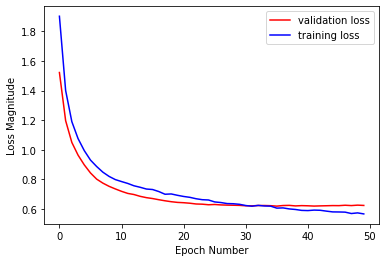

In [42]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['val_loss'],'r',label='validation loss')
plt.plot(history.history['loss'],'b',label='training loss')
plt.legend()

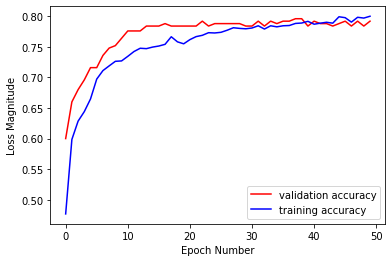

In [43]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['val_accuracy'],'r',label='validation accuracy')
plt.plot(history.history['accuracy'],'b',label='training accuracy')
plt.legend()

## Evaluate accuracy on test dataset

In [44]:
x_test = final.Skill_US[-250:].to_numpy()
y_test = y[-250:]
test_loss, test_accuracy = model.evaluate(x_test,y_test)
print('Accuracy on test dataset:',test_accuracy)

8/8 [==============================] - 0s 10ms/step - loss: 0.6244 - accuracy: 0.7920
Accuracy on test dataset: 0.7919999957084656


## Predictions on test dataset

In [45]:
predicted_probabilities = model.predict(x_test)
predicted_phase = numpy.argmax(predicted_probabilities,axis=-1)
df = final[-250:]
df = df[['Skill_US','Phases']]
df['Predicted Phases'] = predicted_phase
df['Predicted Phases'].replace(mydict,inplace=True)
df.to_excel('Phases-predictions-test.xlsx')
df

,Skill_US,Phases,Predicted Phases
4681,visual design,Design,Design
4682,design software,Design,Software
4683,oracle unified directory,Software,Software
4684,community relations,Support Activities,Support Activities
4685,capacity planning,Supply Chain and Logistics,Support Activities
...,...,...,...
4926,wet chemistry,Materials,Materials
4927,adobe acrobat,Design,Software
4928,engine repair,Tooling and Machining,Tooling and Machining
4929,athenaclinicals,Software,Software


## NaNs

In [46]:
dfnan = original.copy()
dfnan = dfnan.loc[original.Phases.isna()]
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('supply'))&(~dfnan.Skill_US.str.contains('sales')),'Phases'] = 'Design'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('skills')),'Phases'] = 'General Skills'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('discover')),'Phases'] = 'Ideation and Development'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('prototyp')),'Phases'] = 'Ideation and Development'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('material'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('inventory'))&(~dfnan.Skill_US.str.contains('manufactur'))&(~dfnan.Skill_US.str.contains('procurement'))&(~dfnan.Skill_US.str.contains('purchas')),'Phases'] = 'Materials'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('brazing'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('equipment'))&(~dfnan.Skill_US.str.contains('machine')),'Phases'] = 'Production and Assembly'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('manufactur'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('equipment'))&(~dfnan.Skill_US.str.contains('machine')),'Phases'] = 'Production and Assembly'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('production'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('equipment'))&(~dfnan.Skill_US.str.contains('machine')),'Phases'] = 'Production and Assembly'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('soldering'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('equipment'))&(~dfnan.Skill_US.str.contains('machine')),'Phases'] = 'Production and Assembly'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('welding'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('equipment'))&(~dfnan.Skill_US.str.contains('machine')),'Phases'] = 'Production and Assembly'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('software')),'Phases'] = 'Software'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('inventory'))&(~dfnan.Skill_US.str.contains('manufactur'))&(~dfnan.Skill_US.str.contains('market')),'Phases'] = 'Supply Chain and Logistics'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('procurement'))&(~dfnan.Skill_US.str.contains('manufactur'))&(~dfnan.Skill_US.str.contains('market')),'Phases'] = 'Supply Chain and Logistics'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('purchas'))&(~dfnan.Skill_US.str.contains('manufactur'))&(~dfnan.Skill_US.str.contains('market')),'Phases'] = 'Supply Chain and Logistics'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('supplier'))&(~dfnan.Skill_US.str.contains('manufactur'))&(~dfnan.Skill_US.str.contains('market')),'Phases'] = 'Supply Chain and Logistics'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('supply'))&(~dfnan.Skill_US.str.contains('manufactur'))&(~dfnan.Skill_US.str.contains('market')),'Phases'] = 'Supply Chain and Logistics'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('stock'))&(~dfnan.Skill_US.str.contains('manufactur'))&(~dfnan.Skill_US.str.contains('market')),'Phases'] = 'Supply Chain and Logistics'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('management')),'Phases'] = 'Support Activities'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('device'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('sales')),'Phases'] = 'Tooling and Machining'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('equipment'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('sales')),'Phases'] = 'Tooling and Machining'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('instrument'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('sales')),'Phases'] = 'Tooling and Machining'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('machine'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('sales')),'Phases'] = 'Tooling and Machining'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('machine'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('sales')),'Phases'] = 'Tooling and Machining'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('repair'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('sales')),'Phases'] = 'Tooling and Machining'
dfnan.loc[(dfnan.Phases.isna())&(dfnan.Skill_US.str.contains('vehicle'))&(~dfnan.Skill_US.str.contains('design'))&(~dfnan.Skill_US.str.contains('sales')),'Phases'] = 'Tooling and Machining'
dfnan = dfnan.dropna(subset=['Phases'])
print(len(dfnan),'annotated nans')
dfnan.Phases.value_counts()

857 annotated nans


Tooling and Machining         200
Support Activities            172
Design                        172
Supply Chain and Logistics    137
Production and Assembly       109
Materials                      39
Software                       20
Ideation and Development        4
General Skills                  4
Name: Phases, dtype: int64

## Accuracy on NaNs dataset

In [47]:
x_nan = dfnan.Skill_US.to_numpy()
y_nan = dfnan.Phases.str.get_dummies()
y_nan = y_nan.to_numpy()
nan_loss, nan_accuracy = model.evaluate(x_nan,y_nan)
print('Accuracy on nans dataset:',nan_accuracy)

27/27 [==============================] - 0s 8ms/step - loss: 1.1059 - accuracy: 0.6371
Accuracy on nans dataset: 0.63710618019104


## Predictions on NaNs dataset

In [48]:
predicted_probabilities = model.predict(x_nan)
predicted_phase = numpy.argmax(predicted_probabilities,axis=-1)
dfnan = dfnan[['Skill_US','Phases']]
dfnan['Predicted Phases'] = predicted_phase
dfnan['Predicted Phases'].replace(mydict,inplace=True)
dfnan.to_excel('Phases-predictions-nan.xlsx')
dfnan

,Skill_US,Phases,Predicted Phases
4,energy management,Support Activities,Support Activities
23,water distribution system design,Design,Software
25,materials management applications,Materials,Supply Chain and Logistics
32,electrical testing instruments,Tooling and Machining,Tooling and Machining
44,leadership in energy and environmental design ...,Design,Production and Assembling
...,...,...,...
11782,spectrum management,Support Activities,Support Activities
11878,connected vehicle security,Tooling and Machining,Software
11927,ics/ot threat and vulnerability management,Support Activities,Software
11935,iot device management,Support Activities,Software


## Predictions on all 12,016

In [49]:
df = original.copy()
predicted_probabilities = model.predict(df.Skill_US.to_numpy())
predicted_phase = numpy.argmax(predicted_probabilities,axis=-1)
df['Phases'] = predicted_phase
df['Phases'].replace(mydict,inplace=True)
df.to_csv('Phases-predictions.csv',index=False)

## Mixture of annotated with predictions

In [50]:
df1 = original.copy()
predicted_probabilities = model.predict(df1.Skill_US.to_numpy())
predicted_phase = numpy.argmax(predicted_probabilities,axis=-1)
df1['Phases'] = predicted_phase
df1['Phases'].replace(mydict,inplace=True)
df1 = df1[['SkillId','Skill_US','Phases']]
df2 = final.copy()
df2 = df2[['SkillId','Phases']]
df1 = df1.merge(df2,right_on='SkillId',left_on='SkillId',how='left')
df1['Phases'] = df1['Phases_y']
df1.loc[df1.Phases.isna(),'Phases'] = df1['Phases_x']
df1.to_csv('Phases-mixture.csv',index=False)
df1 = df1[['SkillId','Skill_US','Phases']]
df1.to_csv('Phases-mixture.csv',index=False)
df1

,SkillId,Skill_US,Phases
0,3,anxiety reduction,Support Activities
1,5,injections,Software
2,11,hm customs and excise,Support Activities
3,12,behavioral health,Support Activities
4,13,energy management,Support Activities
...,...,...,...
12010,18031,latex,Software
12011,18034,rapid recovery,Software
12012,18035,react javascript,Software
12013,18036,virtual reality (vr),Software


## Get files for the tensorflow projector

In [37]:
import io
out_v = io.open('vecs.tsv','w',encoding='utf-8')
out_m = io.open('meta.tsv','w',encoding='utf-8')
weights = layer_0.get_weights()[0]
for i,phrase in enumerate(final.Skill_US):
  embeddings = weights[i]
  out_m.write(phrase + '\n')
  out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_v.close()
out_m.close()

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['loss'])

In [ ]:
coded.loc[(coded.SkillClusterFamily=='agriculture, horticulture, and the outdoors'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='architecture and construction'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillCluster=='bioinformatics'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillCluster=='biology'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillCluster=='biopharmaceutical manufacturing'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='economics, policy, and social studies'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='education and training')&(coded.SkillCluster!='foreign and language skills')&(coded.SkillCluster!='training programs'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='energy and utilities'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='engineering')&(coded.SkillCluster!='automation engineering')&(coded.SkillCluster!='analog design')&(coded.SkillCluster!='drafting and engineering design')&(coded.SkillCluster!='process engineering')&(coded.SkillCluster!='robotics')&(coded.SkillCluster!='simulation')&(coded.SkillCluster!='simulation software'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='environment'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillCluster=='genetics'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='health Care')&(coded.SkillCluster!='physical abilities'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='industry knowledge')&(coded.SkillCluster!='aluminium industry knowledge')&(coded.SkillCluster!='chemical industry knowledge')&(coded.SkillCluster!='engineering industry knowledge')&(coded.SkillCluster!='metal industy industry knowledge')&(coded.SkillCluster!='plastics material industry knowledge'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='media and writing'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='personal care and services'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='public safety and national Security'),'Phases'] = 'Industry-Specific'
coded.loc[(coded.SkillClusterFamily=='religion'),'Phases'] = 'Industry-Specific'